# 04_evaluation_and_comparison.ipynb
# 1- Configuration & Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import plotly.graph_objects as go
import joblib
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast, pipeline
from lime.lime_text import LimeTextExplainer

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils.visualization_utils import plot_model_comparison_barplot, plot_confusion_matrix
from src.utils.evaluation_utils import load_predictions, load_classification_report

W0519 16:03:45.844000 33456 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


# 2 - Chargement des scores de modèles

In [2]:
results_path = "../results/model_scores_logreg_vs_electra.csv"
df_scores = pd.read_csv(results_path)
df_scores

,Modèle,Accuracy,F1-score
0,TF-IDF + LogReg,0.780350,0.783201
1,ELECTRA,0.821577,0.818834


# 3 - Graphique comparatif des F1-score et Accuracy

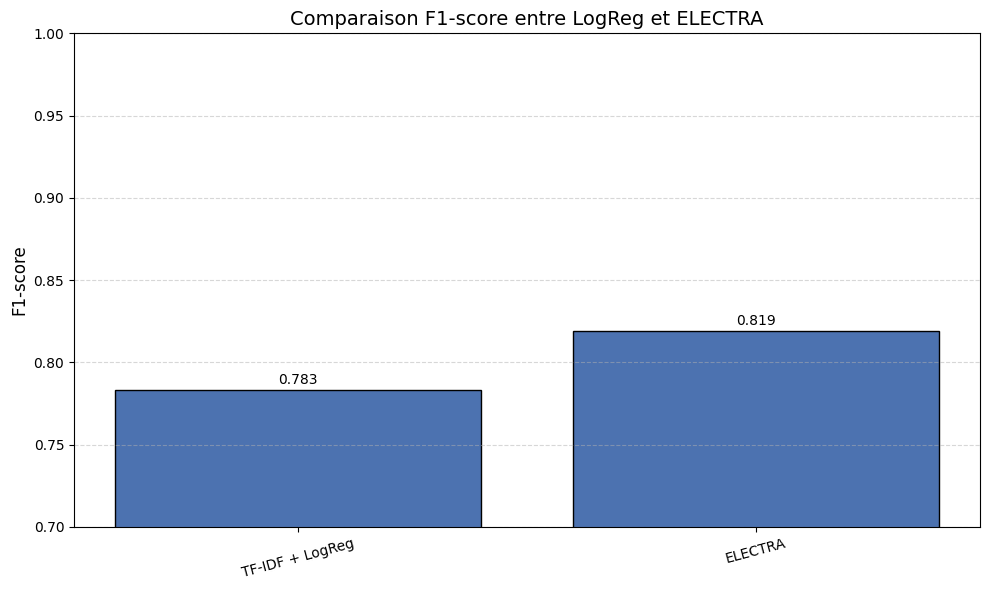

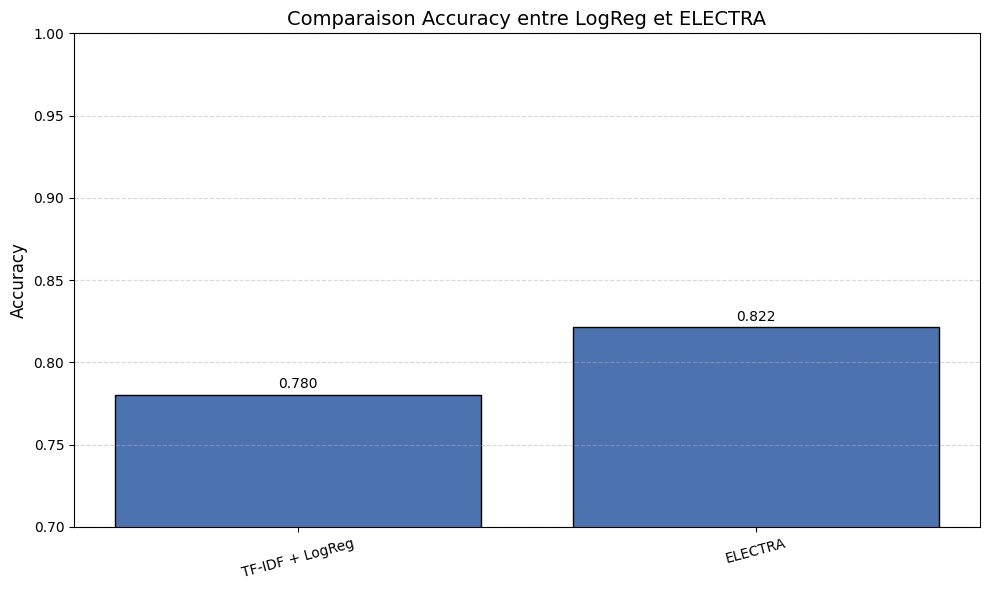

In [3]:
plot_model_comparison_barplot(
    df = df_scores,
    metric_col = "F1-score",
    title = "Comparaison F1-score entre LogReg et ELECTRA",
    save_path = "../results/comparaison_f1.png"
)

plot_model_comparison_barplot(
    df = df_scores,
    metric_col = "Accuracy",
    title = "Comparaison Accuracy entre LogReg et ELECTRA",
    save_path = "../results/comparaison_accuracy.png"
)

# 4 - Matrices de confusion
## 4.1 - Prédictions ELECTRA

In [4]:
df_preds_electra = pd.read_csv("../results/electra_predictions_sample.csv")

## 4.2 - Matrice de confusion ELECTRA

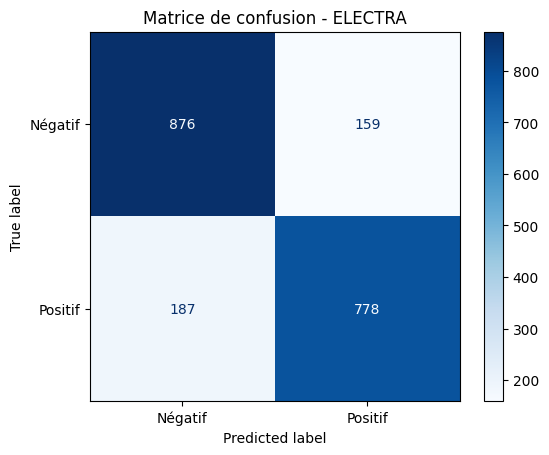

In [5]:
plot_confusion_matrix(
    y_true = df_preds_electra["label"],
    y_pred = df_preds_electra["prediction"],
    labels = ["Négatif", "Positif"],
    title = "Matrice de confusion - ELECTRA",
    save_path = "../results/cm_electra.png"
)

# 5 - Interprétabilité locale (LIME)

In [6]:
model_dir = "../models/electra_model"
model = ElectraForSequenceClassification.from_pretrained(model_dir, local_files_only=True)
tokenizer = ElectraTokenizerFast.from_pretrained(model_dir, local_files_only=True)

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

def classifier_fn_lime(texts):
    preds = pipe(texts)
    return np.array([[p[0]['score'], p[1]['score']] for p in preds])

explainer = LimeTextExplainer(class_names=["Négatif", "Positif"])
tweet_example = df_preds_electra["text"].iloc[0]

explanation = explainer.explain_instance(tweet_example, classifier_fn_lime, num_features=8)
explanation.show_in_notebook(text=tweet_example)

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## Synthèse comparative

- **TF-IDF + LogReg** : modèle très léger (moins de 1 Mo), rapide, interprétable, parfait pour du CPU-only.
- **ELECTRA** : compromis optimal entre performance (≈ 0.83 F1) et poids (≈ 12 Mo), compatible CPU/GPU, rapide en inférence.

## Limites & axes d’amélioration

- Peu d’interprétabilité des modèles Transformers (compensée ici par LIME)
- Possibilités d'optimisation :
  - Quantization, Pruning, Knowledge Distillation
  - Enrichissement du dataset (domain-adapted tweets, ou GoEmotions pour des labels fins)
# 6 - Visualisations des courbes d'entraînement
## 6.1 - Agrégation des checkpoints

In [7]:
checkpoints = ["../tmp_electra/checkpoint-4987",
               "../tmp_electra/checkpoint-9974",
               "../tmp_electra/checkpoint-14961"]

log_history = []

for ckpt in checkpoints:
    state_file = os.path.join(ckpt, "trainer_state.json")
    if os.path.exists(state_file):
        with open(state_file, "r") as f:
            data = json.load(f)
            log_history.extend(data.get("log_history", []))
    else:
        print(f"⚠️ Fichier manquant : {state_file}")

## 6.2 - Extraction des métriques

In [8]:
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
eval_f1 = [log["eval_f1"] for log in log_history if "eval_f1" in log]
eval_accuracy = [log["eval_accuracy"] for log in log_history if "eval_accuracy" in log]
learning_rates = [log["learning_rate"] for log in log_history if "learning_rate" in log]

## 6.3 - Loss

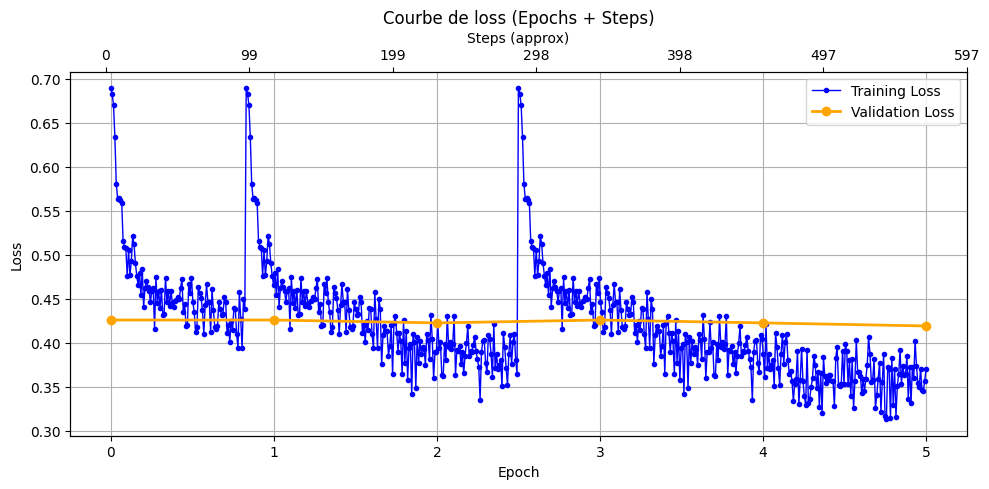

In [9]:
# Nombre de points
num_epochs = len(eval_loss)
num_steps = len(train_loss)

# X principal : epochs (linéarisés)
x_epochs = np.linspace(0, num_epochs - 1, num=num_steps)
x_eval = list(range(num_epochs))

# === Création de la figure avec double axe X ===
fig, ax1 = plt.subplots(figsize=(10, 5))

# Courbe principale : epochs
ax1.plot(x_epochs, train_loss, label="Training Loss", color="blue", marker=".", linewidth=1)
ax1.plot(x_eval, eval_loss, label="Validation Loss", color="orange", marker="o", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.set_title("Courbe de loss (Epochs + Steps)")
ax1.legend(loc="upper right")

# === Ajout de l'axe secondaire X (steps) ===
def epoch_to_step(epoch): return int(epoch * num_steps / num_epochs)
def step_to_epoch(step): return step * num_epochs / num_steps

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
step_ticks = np.linspace(0, num_steps, num=7, dtype=int)
epoch_ticks = [round(step_to_epoch(s), 1) for s in step_ticks]
ax2.set_xticks(epoch_ticks)
ax2.set_xticklabels([str(s) for s in step_ticks])
ax2.set_xlabel("Steps (approx)")

# === Sauvegarde et affichage ===
plt.tight_layout()
plt.savefig("../results/electra_loss_curve_epochs_steps.png")
plt.show()

- Lecture :
    - Training Loss diminue de manière régulière sur l’ensemble des epochs.
    - Validation Loss reste stable autour de 0.41–0.43, et bien positionnée à la fin de chaque epoch, comme attendu.
- Conclusion partielle:
    - Apprentissage progressif, stable et sans rupture brutale.
    - Convergence claire, sans apparition de surapprentissage.
    - La représentation montre que le modèle gagne encore légèrement à chaque epoch, mais tend vers un plateau

## 6.4 - F1 & Accuracy

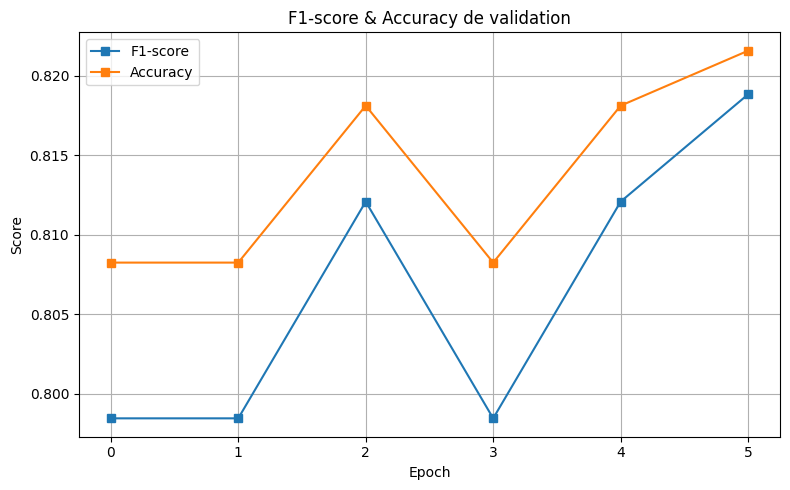

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(eval_f1, label="F1-score", marker="s")
plt.plot(eval_accuracy, label="Accuracy", marker="s")
plt.title("F1-score & Accuracy de validation")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../results/electra_f1_accuracy_curve.png")
plt.show()

- Lecture :
    - Meilleure Accuracy ≈ 0.822, meilleur F1 ≈ 0.819
    - Hausse cohérente des deux métriques, surtout entre les epochs 3 et 5
- Conclusion partielle :
    - Le modèle généralise bien, et ses performances continuent de progresser jusqu’à la dernière epoch.
    - F1 suit bien l’Accuracy, ce qui indique un bon équilibre entre rappel et précision.

## 6.5 - Learning Rate

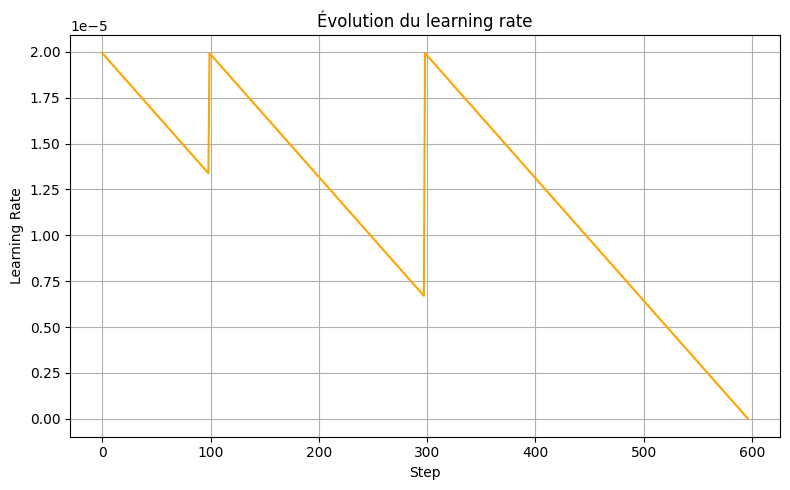

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(learning_rates)), learning_rates, color="orange", label="Learning Rate")
plt.title("Évolution du learning rate")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/electra_learning_rate.png")
plt.show()

- Lecture :
    - Le Learning Rate suit une courbe en dents de scie décroissante, typique d’un scheduler linéaire ou cosine sans warmup.
    - Trois cycles sont visibles :
        - Redémarrage à 2e-5
        - Décroissance jusqu’à ≈ 0
        - Chaque redémarrage correspond à une phase d’apprentissage renouvelée
- Conclusion partielle :
    - Le scheduler est bien calibré et permet de redynamiser l’apprentissage à intervalles réguliers.
    - Les pics de loss en début de cycle sont directement liés aux redémarrages du Learning Rate.
    - La convergence finale est confirmée par la chute du LR à zéro

# 7 - Synthèse globale

| Élément          | Observation                                       | Interprétation                               |
|------------------|---------------------------------------------------|----------------------------------------------|
| 🔁 Loss          | Diminue régulièrement à chaque epoch              | Bonne convergence, pas de surapprentissage   |
| 🧪 F1 / Accuracy | Stables et en hausse epoch après epoch            | Bonne généralisation, encore améliorable     |
| 🔧 Learning rate | Scheduler cohérent et relançant l’apprentissage   | Contrôle progressif de la convergence        |
| 📉 Validation    | Stable autour de 0.41, sans sursaut               | Modèle stable, attention à un éventuel plateau |


In [12]:
# Charger les métriques ELECTRA depuis metrics.pkl
metrics_path = "models/emotions/metrics.pkl"
metrics_data = joblib.load(open(metrics_path, "rb"))

# Garder uniquement les scores entre 0 et 1 pour le barplot
normalized_keys = [
    "f1_micro", "f1_macro", "f1_weighted", "accuracy",
    "roc_auc_micro", "roc_auc_macro", "pr_auc_macro", "lrap"
]
data = {k: v for k, v in metrics_data.items() if k in normalized_keys}

df = pd.DataFrame(data.items(), columns=["Métrique", "Valeur"])
fig = go.Figure(go.Bar(
    x=df["Métrique"],
    y=df["Valeur"],
    text=df["Valeur"].round(3),
    textposition="auto"
))
fig.update_layout(
    title="Comparaison des scores (0 à 1) – Modèle ELECTRA (GoEmotions)",
    yaxis=dict(range=[0, 1], title="Score"),
    xaxis=dict(title="Métriques")
)
fig.show()

In [27]:
from arborescence import afficher_arborescence
afficher_arborescence(project_root, max_niveaux=3)

├── %USERPROFILE%.git-credentials
├── .coverage
├── .git
│   ├── COMMIT_EDITMSG
│   ├── HEAD
│   ├── config
│   ├── description
│   ├── hooks
│   │   ├── applypatch-msg.sample
│   │   ├── commit-msg.sample
│   │   ├── fsmonitor-watchman.sample
│   │   ├── post-update.sample
│   │   ├── pre-applypatch.sample
│   │   ├── pre-commit.sample
│   │   ├── pre-merge-commit.sample
│   │   ├── pre-push.sample
│   │   ├── pre-rebase.sample
│   │   ├── pre-receive.sample
│   │   ├── prepare-commit-msg.sample
│   │   ├── push-to-checkout.sample
│   │   ├── sendemail-validate.sample
│   │   └── update.sample
│   ├── index
│   ├── info
│   │   └── exclude
│   ├── logs
│   │   ├── HEAD
│   │   └── refs
│   ├── objects
│   │   ├── 01
│   │   ├── 03
│   │   ├── 04
│   │   ├── 05
│   │   ├── 06
│   │   ├── 07
│   │   ├── 08
│   │   ├── 0b
│   │   ├── 10
│   │   ├── 12
│   │   ├── 13
│   │   ├── 14
│   │   ├── 1b
│   │   ├── 1e
│   │   ├── 24
│   │   ├── 25
│   │   ├── 2e
│   │   ├── 2f
│   │   ├── 30
│  